# CS4243 Project

1. Clement Ng
2. Kimberley Tay
3. Wayne Tan

## Scraping dataset

1. Images are scraped from google images, duckduckgo images, and unsplash.
2. They are then manually labelled by us.

In [ ]:
#from scraper import main

#main()

## Image Preprocessing

In this step, we will be taking a look at
1. The dataset distribution
2. Normalising of dataset
3. Saving the dataset in a .pt extension for easily reproducible results

In [ ]:
from PIL import Image
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import time, os, torch, shutil

### Checking sizes of images

A few things to note:
1. base_folder defines the folder in which all the images are in.
2. It is assumed that the images are in their respective folders based on their labels, with the folder name being the label, and all of them are in base_folder.

In [ ]:
base_folder = './dataset-raw'
classes = os.listdir(base_folder)
classes = [int(i) for i in classes]
classes.sort()

In [ ]:
def dataset_stats(classes):
    stats = []
    paths = []
    for class_ in classes:
        folder_path = f'{base_folder}/{class_}'
        files = os.listdir(folder_path)
        files.sort()
        for file in files:
            file_path = f'{folder_path}/{file}'
            im = Image.open(file_path)
            size = im.size
            stats.append(size + (min(class_, 11), ))
            paths.append(file_path)
    return np.array(stats), np.array(paths)

In [ ]:
stats, paths = dataset_stats(classes)

<AxesSubplot:ylabel='Count'>

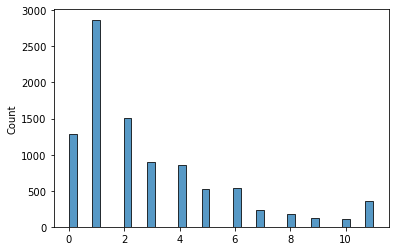

In [ ]:
sns.histplot(x=stats[:, 2])

We observe that the amount of dataset for label 1 is much higher than the rest, so the measure we have chosen to adopt here is to deploy undersampling. Furthermore, for the labels >6, the quantity of dataset available is alot less than those <=6, and based on our decision that 6 is a good number to cut off. The label choice we have decided on will be [0, 1, 2, 3, 4, 5, 6, 7-10,>10].

We have determined that it doesnt make a difference whether there 11 or 12 people in an image, and 6 makes for a size suitable for a small group.

In [ ]:
def get_ratio(stats):
    result = stats[:, 0:2].max(axis=1) / stats[:, 0:2].min(axis=1)
    return result

<AxesSubplot:ylabel='Count'>

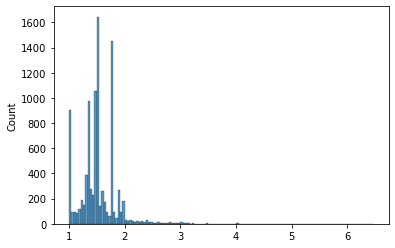

In [ ]:
ratios = get_ratio(stats)
sns.histplot(x=ratios)

Most of the images lie within a boundary of 1 to 2 in aspect ratios, and since we decided to conduct undersampling for majority classes, we will prioritise keeping the images whose aspect ratio lie in this range. In other words, the images whose aspect ratios lie outside this range will be removed with priority.

In [ ]:
size = len(stats)
train_proportion = 0.8
train_size = int(train_proportion*size)
np.random.seed(5)
shuffled_indices = np.random.permutation(np.arange(size))
train_indices = shuffled_indices[:train_size]
test_indices = shuffled_indices[train_size:]
train_set_stats = stats[train_indices]

In [ ]:
print(np.median(train_set_stats, axis = 0))

[339. 249.   2.]


Since the smaller dimension of the median is 249 and we note that 224 x 224 is a common dimension for images resizing for CNN, we have chosen to adopt 224 x 224 as our dimension for images.

### Filtering Images

There are images which are very small compared to the size we have have chosen to keep, which is 224x224. So we will filter the images which are less than 1/4 of the desired size for all.

Furthermore, since there is a majority of dataset for label 0, 1 and 2, we have decided to undersample it, in the following order:
1. Selectively filter based on aspect ratio (so that the amount of black box in the dataset would not be too high.
2. Keep filtering until we have approximately equal to the number of datapoints as the next highest class.

In [ ]:
def filter_small(stats, paths, size=256):
    crit_met = np.logical_and(
        stats[:, 0] >= size/2, stats[:, 1] >= size/2)
    return stats[crit_met], paths[crit_met]

In [ ]:
stats[(stats[:,2] < 11) & (stats[:, 2] > 6), 2] = 7
stats[stats[:,2] >= 11, 2] = 8

From here on, label 7 will represent 7-10 people, and label 8 will denote > 10 people

(9475, 3)
(9233, 3) (9233,)


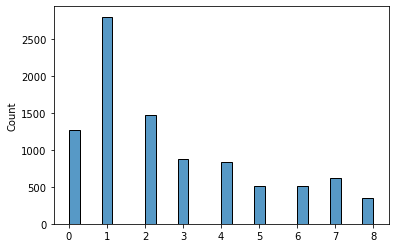

In [ ]:
filtered_stats, filtered_paths = filter_small(stats, paths, 224)
sns.histplot(x=filtered_stats[:, 2])
print(stats.shape)
print(filtered_stats.shape, filtered_paths.shape)

In [ ]:
def undersample(stats, paths):
    labels = np.unique(stats[:, 2])
    count = []
    for label in labels:
        count.append(np.count_nonzero(stats[:, 2] == label))
    count.sort()
    
    retain = count[-4]
    filtered = []
    filtered_paths = []
    for label in labels:
        
        # We scale the aspect ratios so that 1 -> 0, then 
        indices = (stats[:, 2] == label)
        stats_temp = stats[indices]
        paths_temp = paths[indices]
        
        ratio = np.abs(get_ratio(stats_temp) - 1)
        kept_indices = np.argsort(ratio)[: retain]
        filtered.append(stats_temp[kept_indices])
        filtered_paths.append(paths_temp[kept_indices])
    
    filtered = np.concatenate(filtered, axis=0)
    filtered_paths = np.concatenate(filtered_paths, axis=0)
    return filtered, filtered_paths

In [ ]:
images, images_paths = undersample(filtered_stats, filtered_paths)

<AxesSubplot:ylabel='Count'>

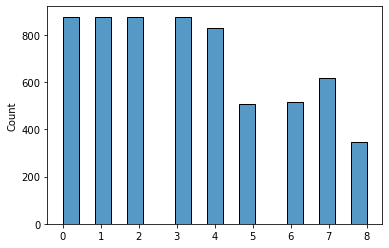

In [ ]:
sns.histplot(x=images[:, 2])

### Normalising Size of images

1. We will be reading the images, converting them to the same size of 224x224, by scaling while retaining aspect ratio, then padding to a square with 0s.
2. If the original image is larger than 256 on either side, it will be scaled down, else the size will remain the same.
3. The dataset will then be saved to a .pt file, and uploaded to a repository so that it can be reproduced easier, instead of uploading all the images as a dataset.
4. This step will only be performed on a local computer with the dataset and does not need to be reproduced when reproducing the results.

In [ ]:
def make_square(im, size=256):
    x, y = im.size
    factor = x / y
    new_size = (size, size)
    if x < y:
        new_size = (int(factor*size), size)
    elif x > y:
        new_size = (size, int(size / factor))
    new_im = Image.new('RGB', (size, size), color=0)
    new_im.paste(im.resize(new_size),
                 (int((size - new_size[0]) / 2), int((size - new_size[1]) / 2)))
    return new_im

In [ ]:
def load_dataset(entries, paths, size=256):
    transformer = transforms.ToTensor()
    dataset = []
    labels = []
    for entry, file_path in zip(entries, paths):
        label = entry[2]
        
        im = Image.open(file_path)
        new_im = make_square(im, size)
        
        dataset.append(transformer(new_im))
        labels.append(label)
        
    dataset = torch.stack(dataset, dim=0)
    labels = torch.tensor(labels)
    return dataset, labels

In [ ]:
size = 224
dataset, labels = load_dataset(images, images_paths, size)

In [ ]:
dataset.size()

torch.Size([6333, 3, 224, 224])

### Saving as a .pt file

The upload limit to github is 100mb per file, so we will save multiple instances.

In [ ]:
total_size = dataset.size(0)
train_indices = train_indices[train_indices < total_size]
test_indices = test_indices[test_indices < total_size]

In [ ]:
def save_data(dataset, name, indices):
    batch_size = 170
    total = indices.size
    for count in range(0, total, batch_size):
        batch_indices = indices[count: count+batch_size]
        batch = None
        if 'labels' in name:
            batch = dataset[batch_indices]
        elif 'data' in name:
            batch = dataset[batch_indices, :, :, :]
        
        if batch != None:
            torch.save(batch, 
                       f'./dataset/{name}/{name}_{(count//batch_size) + 1}.pt')
        else:
            print('Wrong name given')

In [ ]:
save_data(dataset, 'train_data', train_indices)
save_data(labels, 'train_labels', train_indices)
save_data(dataset, 'test_data', test_indices)
save_data(labels, 'test_labels', test_indices)

## Training of the model (Basic CNN)

The main goals of this step is to
1. Perform a Vanilla CNN
2. Try to develop a more advanced structure mainly based on the hierarichal features idea taught in class

### Getting dataset

Using the requests module to download the dataset from our repo. (For use when running the notebook from collab where the files have yet to be downloaded)

In [ ]:
import os, torch

In [ ]:
files = {
    'train_data': [
        'https://github.com/ClementNgZiQian/CS4243_2122S2_Project/blob/main/dataset/train_data/train_data_1.pt?raw=true',
        30
    ],
    'train_labels': [
        'https://github.com/ClementNgZiQian/CS4243_2122S2_Project/blob/main/dataset/train_labels/train_labels_1.pt?raw=true',
        30
    ],
    'test_data': [
        'https://github.com/ClementNgZiQian/CS4243_2122S2_Project/blob/main/dataset/test_data/test_data_1.pt?raw=true',
        8
    ],
    'test_labels': [
        'https://github.com/ClementNgZiQian/CS4243_2122S2_Project/blob/main/dataset/test_labels/test_labels_1.pt?raw=true',
        8
    ],
}

In [ ]:
import requests
base_folder = './dataset'

def check_dataset(files):
    for type_, info in files.items():
        if not os.path.exists(os.path.join(base_folder, type_)):
            os.makedirs(os.path.join(base_folder, type_))
        url = info[0]
        
        for i in range(info[-1]):
            name = f'{type_}_{i+1}'
            file_path = f'{base_folder}/{type_}/{name}.pt'
            if not os.path.exists(file_path):
                r = requests.get(url.replace(f'{type_}_1', name))
                with open(file_path, 'wb') as f:
                    f.write(r.content)

not_found = check_dataset(files)

In [ ]:
def load_dataset(type_):
    folder = os.path.join(base_folder, type_)
    files = os.listdir(folder)
    files = [os.path.join(folder, i) for i in files]
    files.sort()
    result = torch.load(files[0])
    for file in files[1:]:
        result = torch.cat((result, torch.load(file)), dim=0)
    return result

In [ ]:
train_data = load_dataset('train_data')
train_label = load_dataset('train_labels')
test_data = load_dataset('test_data')
test_label = load_dataset('test_labels')

In [ ]:
print(train_data.shape)
print(test_data.shape)

torch.Size([5091, 3, 224, 224])
torch.Size([1242, 3, 224, 224])


### Helper functions for training model multiple times

In [ ]:
def get_accuracy(scores, labels):
    bs = labels.size(0)
    predicted_labels = scores.argmax(dim=1)
    indicator = (predicted_labels == labels)
    num_error = indicator.sum()
    return num_error.float()/bs

In [ ]:
def train_model(model, criterion, train_data, train_label, 
                epochs, normalize=True, bs=100, lr=0.1):
    
    #torch.autograd.set_detect_anomaly(True)
    start = time.time()
    train_size = train_data.size(0)
    num_batches = (train_size // bs) + 1
    losses = np.zeros([epochs])
    accuracies = np.zeros([epochs])
    
    mean = train_data.mean()
    mean = mean.to(device)
    std = train_data.std()
    std = std.to(device)
    
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0
        
        if epoch % 10 == 9:
            lr = lr / 2
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        shuffled_indices = torch.randperm(train_size)
        
        for count in range(0, train_size, bs):
            optimizer.zero_grad()
            
            indices = shuffled_indices[count: count+bs]
            minibatch_data = train_data[indices]
            minibatch_label = train_label[indices]
            
            minibatch_data = minibatch_data.to(device)
            minibatch_label = minibatch_label.to(device)
            
            if normalize:
                minibatch_data = (minibatch_data - mean) / std
            
            minibatch_data.requires_grad_()
            
            scores = model(minibatch_data)
            loss = criterion(scores, minibatch_label)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.detach().item()
            epoch_accuracy += get_accuracy(scores, minibatch_label).item()
        
        accuracies[epoch] = epoch_accuracy/num_batches
        
        losses[epoch] = epoch_loss/num_batches
        
        if epoch % 10 == 9:
            elapsed = time.time() - start
            print(f'Epoch = {epoch}, Time = {elapsed/60:.3f}min, \
              Loss={losses[epoch]:.3f}, Accuracy={accuracies[epoch]*100:.3f}%')
    
    return model, accuracies, losses

In [ ]:
def test_model(model, test_data, test_label, 
               bs=100, normalize=True):
    
    accuracy = 0
    test_size = test_label.size(0)
    num_batches = (test_size // bs) + 1
    
    mean = train_data.mean()
    mean = mean.to(device)
    std = train_data.std()
    std = std.to(device)
    
    for count in range(0, test_size, bs):
        minibatch_data = test_data[count: count+bs]
        minibatch_label = test_label[count: count+bs]
        
        minibatch_data = minibatch_data.to(device)
        minibatch_label = minibatch_label.to(device)
        
        if normalize:
            minibatch_data = (minibatch_data - mean) / std
        
        scores = model(minibatch_data)
        accuracy += get_accuracy(scores, minibatch_label).item()
    
    accuracy = accuracy / num_batches
    return accuracy

In [ ]:
def plot_accuracies(train_accuracy, test_accuracy):
    plt.plot(train_accuracy, label='Train Accuracy')
    plt.plot(test_accuracy * np.ones(train_accuracy.shape), label='Test Accuracy')
    plt.legend()
    plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [ ]:
def get_metrics(model, test_data, test_label, device):
    
    test_size = test_label.size(0)
    
    mean = test_data.mean()
    mean = mean.to(device)
    std = test_data.std()
    std = std.to(device)
    accuracy = 0
    precision = 0
    recall = 0
    f1 = 0
    
    inputs = test_data.to(device)
    test_label = test_label.to(device)
    inputs = (inputs - mean) / std
    scores = model(inputs)  
    predicted_label = scores.cpu().argmax(dim=1).detach().numpy()
    test_labels = test_label.cpu().detach().numpy()
    
    accuracy += accuracy_score(predicted_label, test_label)
    precision += precision_score(predicted_label, test_label, average = 'weighted')
    recall += recall_score(predicted_label, test_label, average = 'weighted')
    f1 += f1_score(predicted_label, test_label, average = 'weighted')
    
    return accuracy, precision, recall, f1

We had planned to use k-fold to do hyper parmas searching, but it ended up requiring too much memory and there was insufficient time for us to find a solution, so we decided to not include it in the report.

In [ ]:
def reset_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()
        
def k_fold(model, k, train_data, train_label, criterion, device, epochs):
    cv = 0
    size = train_label.size
    model.apply(reset_weights)
    shuffled_indices = torch.randperm(size)
    
    for i in range(k):
        test_indices = shuffled_indices[i*(size//k): (i+1)*(size//k)]
        train_indices = torch.cat((shuffled_indices[: i*(size//k)], \
                                   shuffled_indices[(i+1)*(size//k):]), axis=0)
        
        train_data_k = train_data[train_indices]
        train_label_k = train_label[train_indices]
        test_data_k = train_data[test_indices]
        test_label_k = train_label[test_indices]
        
        model, train_accuracy, train_loss = \
            train_model(model, criterion, train_data_k, train_label_k)
        
        cv += test_model(model, test_data_k, test_label_k)
    
    return cv/k

In [ ]:
def save_model(name, model, train_accuracy):
    folder_path = os.path.join('./models', name)
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    torch.save(model.state_dict(), os.path.join(folder_path, 'model_state.pt'))
    torch.save(train_accuracy, os.path.join(folder_path, 'train_accuracy.pt'))
    
def load_model(name):
    model_state = torch.load(os.path.join('./models', name, 'model_state.pt'))
    train_accuracy = torch.load(os.path.join('./models', name, 'train_accuracy.pt'))
    return model_state, train_accuracy

### Vanilla CNN

We will begin with a simple CNN model, with 1 convolutional and linear layer each

In [ ]:
import torch.nn as nn
import time
import numpy as np
from matplotlib import pyplot as plt

device = torch.device('cuda')

In [ ]:
size = np.array([224, 224])

class Vanilla_CNN(nn.Module):
    
    def __init__(self, hidden_dim, output_dim):
        super(Vanilla_CNN, self).__init__()
        
        self.linear_dim = hidden_dim*size.prod()
        self.conv = nn.Conv2d(3, hidden_dim, kernel_size=3, padding=1)
        self.linear = nn.Linear(self.linear_dim, output_dim)
    
    def forward(self, x):
        # 3 x 224 x 224 -> hidden_dim x 224 x 224
        x = self.conv(x)
        x = torch.relu(x)
        # hidden_dim x 224 x 224 -> hidden_dim*224*224
        x = x.view(-1, self.linear_dim)
        # hidden_dim*224*224 -> 9
        x = self.linear(x)
        return x

In [ ]:
net = Vanilla_CNN(32, 9)
net = net.to(device)
criterion = nn.CrossEntropyLoss()
net, train_accuracy, train_loss = \
    train_model(net, criterion, train_data, train_label.long(), epochs=100, lr=0.2)

save_model('van_cnn', net, train_accuracy)

Epoch = 9, Time = 0.822min,               Loss=2.164, Accuracy=14.543%
Epoch = 19, Time = 1.530min,               Loss=2.161, Accuracy=13.008%
Epoch = 29, Time = 2.237min,               Loss=2.160, Accuracy=13.096%
Epoch = 39, Time = 2.945min,               Loss=2.159, Accuracy=13.300%
Epoch = 49, Time = 3.654min,               Loss=2.157, Accuracy=13.064%
Epoch = 59, Time = 4.362min,               Loss=2.157, Accuracy=14.061%
Epoch = 69, Time = 5.072min,               Loss=2.157, Accuracy=14.059%
Epoch = 79, Time = 5.782min,               Loss=2.157, Accuracy=14.074%
Epoch = 89, Time = 6.490min,               Loss=2.157, Accuracy=14.064%
Epoch = 99, Time = 7.205min,               Loss=2.157, Accuracy=14.062%


In [ ]:
net = Vanilla_CNN(32, 9)
model_state, train_accuracy = load_model('van_cnn')
net.load_state_dict(model_state)
net = net.to(device)

In [ ]:
test_accuracy = 0
with torch.no_grad():
    test_accuracy = test_model(net, test_data, test_label)

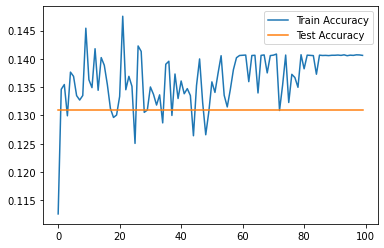

In [ ]:
plot_accuracies(train_accuracy, test_accuracy)

### Simplification of the problem

After consulting out TA on why our test error is still high even though our training loss was low, we were advised to simplify our problem into a 5-class classification where we classified images with at most 4 people.

In [ ]:
mask_train = train_label <= 4
mask_test = test_label <= 4


train_label_2 = train_label[mask_train]
train_data_2 = train_data[mask_train]
test_label_2 = test_label[mask_test]
test_data_2 = test_data[mask_test]

In [ ]:
print(train_data_2.shape)
print(test_data_2.shape)

torch.Size([3480, 3, 224, 224])
torch.Size([861, 3, 224, 224])


In [ ]:
net = Vanilla_CNN(32, 5)
net = net.to(device)
criterion = nn.CrossEntropyLoss()
van_net_2, train_accuracy, train_loss = \
    train_model(net, criterion, train_data_2, train_label_2.long(), epochs=100, lr=0.2)

save_model('van_cnn_2', net, train_accuracy)

Epoch = 9, Time = 0.463min,               Loss=1.615, Accuracy=19.757%
Epoch = 19, Time = 0.904min,               Loss=1.613, Accuracy=20.329%
Epoch = 29, Time = 1.347min,               Loss=1.612, Accuracy=19.643%
Epoch = 39, Time = 1.791min,               Loss=1.610, Accuracy=19.793%
Epoch = 49, Time = 2.234min,               Loss=1.610, Accuracy=20.579%
Epoch = 59, Time = 2.678min,               Loss=1.610, Accuracy=20.543%
Epoch = 69, Time = 3.123min,               Loss=1.609, Accuracy=20.557%
Epoch = 79, Time = 3.569min,               Loss=1.609, Accuracy=20.564%
Epoch = 89, Time = 4.016min,               Loss=1.609, Accuracy=20.543%
Epoch = 99, Time = 4.462min,               Loss=1.609, Accuracy=20.564%


In [ ]:
net = Vanilla_CNN(32, 5)
model_state, train_accuracy = load_model('van_cnn_2')
net.load_state_dict(model_state)
net = net.to(device)

In [ ]:
test_accuracy = 0
with torch.no_grad():
    test_accuracy = test_model(net, test_data_2, test_label_2)

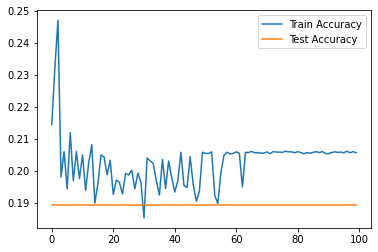

In [ ]:
plot_accuracies(train_accuracy, test_accuracy)

Noting that there was not a significant increase in performance, we tried to add more layers to the Vanilla CNN (4 convolutional layers) and we set the hidden_dim to be a hyperparameter. The idea behind using 4 layers is because of hierarichal features, as layer 3 is the minimum to guarantee complex features, we decided to go with 4 because clearly people counting is as complex if not more complex than normal image identification.

In [ ]:
class new_Vanilla_CNN(nn.Module):
    
    def __init__(self, hidden_dim, output_dim):
        super(new_Vanilla_CNN, self).__init__()
        
        self.linear_dim = hidden_dim*8*14*14
        self.conv1 = nn.Conv2d(3, hidden_dim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(hidden_dim, hidden_dim * 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(hidden_dim * 2, hidden_dim * 4, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(hidden_dim * 4, hidden_dim * 8, kernel_size=3, padding=1)
        self.linear = nn.Linear(self.linear_dim, output_dim)
        self.pool1 = nn.MaxPool2d(2,2)
        self.pool2 = nn.MaxPool2d(2,2)
        self.pool3 = nn.MaxPool2d(2,2)
        self.pool4 = nn.MaxPool2d(2,2)
    
    def forward(self, x):
        # 3 x 224 x 224 -> hidden_dim x 112 x 112
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.pool1(x)
        # hidden_dim x 112 x 112 -> hidden_dim * 2 x 56 x 56
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.pool2(x)
        # hidden_dim * 2 x 56 x 56 -> hidden_dim * 4 x 28 x 28
        x = self.conv3(x)
        x = torch.relu(x)
        x = self.pool3(x)
        # hidden_dim * 4 x 28 x 28 -> hidden_dim * 8 x 14 x 14
        x = self.conv4(x)
        x = torch.relu(x)
        x = self.pool4(x)
        # hidden_dim * 8 x 14 x 14 -> hidden_dim*8*14*14
        x = x.view(-1, self.linear_dim)
        # hidden_dim*8*14*14 -> 9
        x = self.linear(x)
        return x

In [ ]:
net = new_Vanilla_CNN(32, 5)
net = net.to(device)
criterion = nn.CrossEntropyLoss()
net, train_accuracy, train_loss = \
    train_model(net, criterion, train_data_2, train_label_2.long(), epochs=100, lr=0.2)

save_model('cnn_4layers', net, train_accuracy)

C:\Users\Clement Ng\miniconda3\envs\deeplearn_course\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch = 9, Time = 1.002min,               Loss=1.619, Accuracy=18.971%
Epoch = 19, Time = 1.981min,               Loss=1.612, Accuracy=21.443%
Epoch = 29, Time = 2.977min,               Loss=1.611, Accuracy=19.029%
Epoch = 39, Time = 3.982min,               Loss=1.610, Accuracy=19.721%
Epoch = 49, Time = 4.988min,               Loss=1.610, Accuracy=19.429%
Epoch = 59, Time = 6.006min,               Loss=1.610, Accuracy=19.721%
Epoch = 69, Time = 7.030min,               Loss=1.609, Accuracy=20.579%
Epoch = 79, Time = 8.051min,               Loss=1.609, Accuracy=20.564%
Epoch = 89, Time = 9.080min,               Loss=1.609, Accuracy=20.586%
Epoch = 99, Time = 10.113min,               Loss=1.609, Accuracy=20.557%


In [ ]:
net = new_Vanilla_CNN(32, 5)
model_state, train_accuracy = load_model('cnn_4layers')
net.load_state_dict(model_state)
net = net.to(device)

In [ ]:
test_accuracy = 0
with torch.no_grad():
    test_accuracy = test_model(net, test_data_2, test_label_2)

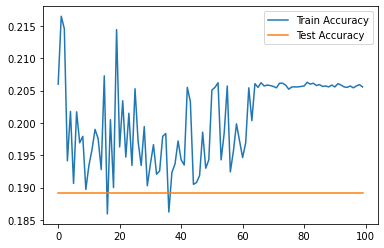

In [ ]:
plot_accuracies(train_accuracy, test_accuracy)

### Multi-column CNN (MCNN)

Observing that there was not much improvement in the performance of the model, we try a Multi-column CNN which should perform better than a vanilla CNN.

In [ ]:
class MCNN(nn.Module):
    
    def __init__(self, hidden1, hidden2, hidden3, output_dim):
        super(MCNN, self).__init__()
        
        self.linear_dim = 56**2
        
        self.linear = nn.Linear(self.linear_dim, output_dim)
        
        self.branch1 = nn.Sequential(nn.Conv2d(3, hidden1, kernel_size= 9, padding=4),
                                     nn.MaxPool2d(2,2),
                                     nn.Conv2d(hidden1, hidden1*2, kernel_size= 7, padding=3),
                                     nn.MaxPool2d(2,2),
                                     nn.Conv2d(hidden1*2, hidden1, kernel_size= 7, padding=3),
                                     nn.Conv2d(hidden1,  hidden1//2, kernel_size= 7, padding=3))
        
        self.branch2 = nn.Sequential(nn.Conv2d(3, hidden2, kernel_size= 7, padding=3),
                                     nn.MaxPool2d(2,2),
                                     nn.Conv2d(hidden2, hidden2*2, kernel_size= 5 ,padding=2),
                                     nn.MaxPool2d(2,2),
                                     nn.Conv2d(hidden2*2, hidden2, kernel_size= 5 ,padding=2),
                                     nn.Conv2d(hidden2, hidden2//2, kernel_size= 5 ,padding=2))
        
        self.branch3 = nn.Sequential(nn.Conv2d(3, hidden3, kernel_size= 5 ,padding=2),
                                     nn.MaxPool2d(2,2),
                                     nn.Conv2d(hidden3, hidden3*2, kernel_size= 3 ,padding=1),
                                     nn.MaxPool2d(2,2),
                                     nn.Conv2d(hidden3*2, hidden3, kernel_size= 3 ,padding=1),
                                     nn.Conv2d(hidden3, hidden3//2, kernel_size= 3 ,padding=1))
        
        self.fuse = nn.Sequential(nn.Conv2d((hidden1+hidden2+hidden3)//2, 1, kernel_size= 1, padding=0))
        
    def forward(self, x):
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        x = torch.cat((x1,x2,x3), 1)
        x = self.fuse(x)
        x = torch.relu(x)
        x = x.view(-1, self.linear_dim)
        x = self.linear(x)
        return x


In [ ]:
net = MCNN(16, 20, 24, 5)
net = net.to(device)
criterion = nn.CrossEntropyLoss()
net, train_accuracy, train_loss = \
    train_model(net, criterion, train_data_2, train_label_2.long(), epochs=30, lr=0.2)

save_model('mcnn', net, train_accuracy)

Epoch = 9, Time = 2.722min,               Loss=1.616, Accuracy=20.386%
Epoch = 19, Time = 5.486min,               Loss=1.613, Accuracy=18.986%
Epoch = 29, Time = 8.249min,               Loss=1.614, Accuracy=19.243%


In [ ]:
net = MCNN(16, 20, 24, 5)
model_state, train_accuracy = load_model('mcnn')
net.load_state_dict(model_state)
net = net.to(device)

In [ ]:
test_accuracy = 0
with torch.no_grad():
    test_accuracy = test_model(net, test_data_2, test_label_2)

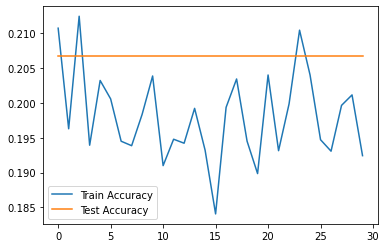

In [ ]:
plot_accuracies(train_accuracy, test_accuracy)

## Object Detection / Image Segmentation

The main goals of this step is to
1. Perform a Faster-RCNN
2. Test for the accuracy of this model compared to the network we created, for the purpose of the research of future improvements that can be integrated into our network to improve the accuracy rates

At this point, we realised that the most probable reason that the network still failed was due to it being a normal CNN and not object detection model.
1. Counting people would first require the network to identify which sections have people, and then from there count how many people. 
2. Our data is not labelled with bounding boxes due to time constraint and difficulty in labelling so many images with just 3 people, we have decided to try use a pretrained object detector model and from there use its results to count the number of people.

In [1]:
!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

#exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

     |████████████████████████████████| 274 kB 4.9 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=489bcb69bfae7a56d28540c68fa9e5c521f713a0262b91eba74dcfb1f09cc83a
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
torch:  1.10 ; cuda:  cu111
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html
     |████████████████████████████████| 7.0 MB 959 kB/s 
     |████████████████████████████████| 130 kB 5.0 MB/s 
     |████████████████████████████████| 50 kB 1.9 MB/s 
     |████████████████████████████████| 147 kB 9.5 MB/s 
     |████████████████████████████████| 74 kB 2.6 MB/s 
     |████████████████████████████████| 843 kB 9.9 MB/s 
     |████████████████████████████████| 

In [1]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
import time
import matplotlib.pyplot as plt
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [2]:
import os
if not os.path.exists('./dataset_png'):
    !wget https://github.com/ClementNgZiQian/CS4243_2122S2_Project/releases/download/v1.0/dataset_png.zip 
    !unzip dataset_png.zip > /dev/null

In [3]:
def detectron_count(predictor, base_folder, class_number):
    start = time.time()
    batch_folders = os.listdir(base_folder)
    correct = 0
    total_size = 0
    for folder in batch_folders:
        folder_path = f'{base_folder}/{folder}'
        images = os.listdir(folder_path)
        labels_path = folder_path.replace('_data', '_labels') + '.pt'
        labels = torch.load(labels_path)
        total_size += len(labels)
        for i in range(len(labels)):
            im_path = f'{folder_path}/{i}.png'
            label = labels[i]
            im = cv2.imread(im_path)
        
            outputs = predictor(im)
            preds = outputs['instances'].pred_classes.to('cpu')
            count = torch.count_nonzero(preds == class_number)  
            correct += (count == label)
        
        curr = time.time()
        print(f'Time passed = {(curr-start)/60:.3f}min, {total_size} images processed')

    accuracy = (correct/total_size) * 100
    return accuracy

In [4]:
def run_inf(pre_trained, ROI):
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(pre_trained))
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = ROI  # set threshold for this model
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(pre_trained)
    predictor = DefaultPredictor(cfg)
    train_accuracy = detectron_count(predictor, './dataset_png/train_data', 0)
    test_accuracy = detectron_count(predictor, './dataset_png/test_data', 0)
    return train_accuracy, test_accuracy

In [5]:
def plot_accuracies_detectron(test_accuracy, train_accuracy):
    plt.plot(train_accuracy * np.ones(10), label='Train Accuracy')
    plt.plot(test_accuracy * np.ones(10), label='Test Accuracy')
    plt.legend()
    plt.show()

#### Running Inference using - **COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml**

We create a detectron2 config and a detectron2 `DefaultPredictor` to run inference on image.

In [6]:
import torch
ROI = 0.5
start = time.time()
accuracy_detectron_2train, accuracy_detectron_2test = \
        run_inf("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml", ROI)
end = time.time()
print(f'Train set accuracy = {accuracy_detectron_2train:.3f}%, \
    Test set accuracy = {accuracy_detectron_2test:.3f}%, \
    time taken = {(end - start)/60:.3f}mins')

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Time passed = 0.851min, 170 images processed
Time passed = 1.703min, 340 images processed
Time passed = 2.556min, 510 images processed
Time passed = 3.412min, 680 images processed
Time passed = 4.262min, 850 images processed
Time passed = 5.114min, 1020 images processed
Time passed = 5.797min, 1156 images processed
Time passed = 6.647min, 1326 images processed
Time passed = 7.501min, 1496 images processed
Time passed = 8.351min, 1666 images processed
Time passed = 9.200min, 1836 images processed
Time passed = 10.050min, 2006 images processed
Time passed = 10.902min, 2176 images processed
Time passed = 11.753min, 2346 images processed
Time passed = 12.604min, 2516 images processed
Time passed = 13.455min, 2686 images processed
Time passed = 14.302min, 2856 images processed
Time passed = 15.148min, 3026 images processed
Time passed = 15.997min, 3196 images processed
Time passed = 16.845min, 3366 images processed
Time passed = 17.689min, 3536 images processed
Time passed = 18.536min, 3706

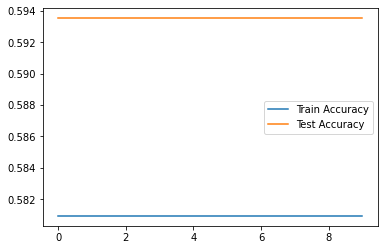

In [7]:
plot_accuracies_detectron(accuracy_detectron_2test/100, accuracy_detectron_2train/100)

#### Running Inference using - **COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml**

We create a detectron2 config and a detectron2 `DefaultPredictor` to run inference on image.

In [8]:
ROI = 0.5
start = time.time()
accuracy_detectron_2train, accuracy_detectron_2test = \
        run_inf("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml", ROI)
end = time.time()
print(f'Train set accuracy = {accuracy_detectron_2train:.3f}%, \
    Test set accuracy = {accuracy_detectron_2test:.3f}%, \
    time taken = {(end - start)/60:.3f}mins')

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


Time passed = 3.166min, 170 images processed
Time passed = 6.331min, 340 images processed
Time passed = 9.501min, 510 images processed
Time passed = 12.668min, 680 images processed
Time passed = 15.833min, 850 images processed
Time passed = 18.999min, 1020 images processed
Time passed = 21.531min, 1156 images processed
Time passed = 24.697min, 1326 images processed
Time passed = 27.868min, 1496 images processed
Time passed = 31.033min, 1666 images processed
Time passed = 34.197min, 1836 images processed
Time passed = 37.362min, 2006 images processed
Time passed = 40.526min, 2176 images processed
Time passed = 43.689min, 2346 images processed
Time passed = 46.855min, 2516 images processed
Time passed = 50.018min, 2686 images processed
Time passed = 53.184min, 2856 images processed
Time passed = 56.347min, 3026 images processed
Time passed = 59.514min, 3196 images processed
Time passed = 62.681min, 3366 images processed
Time passed = 65.846min, 3536 images processed
Time passed = 69.014m

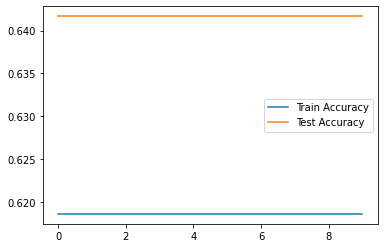

In [9]:
plot_accuracies_detectron(accuracy_detectron_2test/100, accuracy_detectron_2train/100)

## Our conclusion:

From the results above, it shows the image segmentation model giving much higher accuracy rates, which were around 59-64%, as compared to the other networks which were trained on our dataset, which gave lower accuracy rates of around 20%. From here, our team has concluded that image segmentation model could be integrated into our future implementations as part of the solution to our intial problem.

Additionally, the results displayed above has shown a higher accuracy rate for the 2nd model, which  as compared to the 1st model. From here, our team learned that the difference in learning rate schedules affects the accuracy rates predicted by the model. The results has shown that the models trained with a higher number of epochs/iterations gave predictions with higher accuracy rates.